Libraries

In [21]:
# data manipulation
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict, Sequence, Union, Optional
from math import comb
import matplotlib.pyplot as plt
from itertools import combinations

# data preprocessing
from sklearn.preprocessing import StandardScaler

# classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_selection import mutual_info_regression

# qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter

# saving and loading
import json
import os

Load and preprocess dataset

In [3]:
dataset_save = "C:/Users/jiriv/Documents/škola/Diplom_thesis/Quantum-feature-maps/Dataset/Toxicity-13F.csv"
df = pd.read_csv(dataset_save)
df['Class'] = df['Class'].apply(lambda v: 1 if str(v).strip().lower().startswith('non') else 0) # Convert 'non-toxic' to 0 and 'toxic' to 1
X_raw = df.iloc[:, :-1].values   # shape (171,13)
y = df.iloc[:, -1].values        # binary targets: toxic (1) or not (0)

# Show the first few rows of the dataframe
print(df.head(), "\n")
# Show example of both target classes
print("Example of non-toxic sample (Class=0):")
print(df[df['Class'] == 0].head(1), "\n")
print("Example of toxic sample (Class=1):")
print(df[df['Class'] == 1].head(1), "\n")

# Standardize features (zero mean, unit variance)
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

   MDEC-23  MATS2v   ATSC8s    VE3_Dt  CrippenMR  SpMax7_Bhe  SpMin1_Bhs  \
0  60.1757 -0.0231  -0.6667 -167.1241     0.0000      3.4009      2.3109   
1  44.5031 -0.1236 -16.5096  -16.2080   172.2000      3.3611      2.1117   
2  37.5488  0.0662  19.3467 -159.1796   173.4028      3.2705      2.0198   
3  40.5929  0.0714  -9.5672  -21.4416   177.2726      3.2748      2.0191   
4  52.7343 -0.0861 -11.8892   -2.0780   171.1315      3.4094      2.1664   

   C1SP2  GATS8e  GATS8s  SpMax5_Bhv  VE3_Dzi   VPC-4  Class  
0      4  1.0229  1.0575      3.5545 -15.5940  4.1692      1  
1      2  1.7155  1.7013      3.6066 -14.3317  2.0821      1  
2      8  0.6992  0.7828      3.6441 -25.4493  2.8730      1  
3      6  0.9951  1.0298      3.6564 -19.6376  3.0444      1  
4      2  0.7363  0.7427      3.5216  -8.2157  2.9469      1   

Example of non-toxic sample (Class=0):
    MDEC-23  MATS2v   ATSC8s  VE3_Dt  CrippenMR  SpMax7_Bhe  SpMin1_Bhs  \
85  40.3072  0.0575  11.0331 -8.4659   167.5747  

Compute hamiltonian coefficients (Section: Hamiltonian based encoding)

In [5]:
def pairwise_mi_hist(X: np.ndarray, cols: Optional[Sequence[int]] = None, bins: int = 10) -> np.ndarray:
    if cols is None:
        cols = list(range(X.shape[1]))
    m = len(cols)
    mi_mat = np.zeros((m, m), dtype=float)
    for i_idx, i in enumerate(cols):
        xi = X[:, i]
        for j_idx, j in enumerate(cols[i_idx+1:], start=i_idx+1):
            xj = X[:, j]
            if np.allclose(xi, xi[0]) or np.allclose(xj, xj[0]):
                mij = 0.0
            else:
                counts_xy, _, _ = np.histogram2d(xi, xj, bins=bins)
                p_xy = counts_xy / counts_xy.sum()
                p_x = p_xy.sum(axis=1)
                p_y = p_xy.sum(axis=0)
                idx = np.where(p_xy > 0)
                pij = p_xy[idx]
                px = p_x[idx[0]]
                py = p_y[idx[1]]
                mij = float(np.sum(pij * np.log(pij / (px * py) + 1e-12)))
            mi_mat[i_idx, j_idx] = mij
            mi_mat[j_idx, i_idx] = mij
    return mi_mat

def pairwise_mi_gauss(X: np.ndarray, cols: Optional[Sequence[int]] = None) -> np.ndarray:
    if cols is None:
        cols = list(range(X.shape[1]))
    m = len(cols)
    mi_mat = np.zeros((m, m), dtype=float)
    for i_idx, i in enumerate(cols):
        xi = X[:, i]
        for j_idx, j in enumerate(cols[i_idx+1:], start=i_idx+1):
            xj = X[:, j]
            if np.allclose(xi, xi[0]) or np.allclose(xj, xj[0]):
                mij = 0.0
            else:
                rho = np.corrcoef(xi, xj)[0,1]
                rho = np.clip(rho, -1 + 1e-12, 1 - 1e-12)
                mij = -0.5 * np.log(1 - rho*rho)
            mi_mat[i_idx, j_idx] = mij
            mi_mat[j_idx, i_idx] = mij
    return mi_mat

def pairwise_mi_knn(X: np.ndarray, cols: Optional[Sequence[int]] = None,
                    n_neighbors: int = 3, random_state: Optional[int] = None) -> np.ndarray:
    if cols is None:
        cols = list(range(X.shape[1]))
    m = len(cols)
    mi_mat = np.zeros((m, m), dtype=float)
    for i_idx, i in enumerate(cols):
        xi = X[:, i]
        for j_idx, j in enumerate(cols[i_idx+1:], start=i_idx+1):
            xj = X[:, j]
            if np.allclose(xi, xi[0]) or np.allclose(xj, xj[0]):
                mij = 0.0
            else:
                mi_ij = mutual_info_regression(xi.reshape(-1,1), xj, n_neighbors=n_neighbors, random_state=random_state)[0]
                mi_ji = mutual_info_regression(xj.reshape(-1,1), xi, n_neighbors=n_neighbors, random_state=random_state)[0]
                mij = 0.5 * (mi_ij + mi_ji)
            mi_mat[i_idx, j_idx] = mij
            mi_mat[j_idx, i_idx] = mij
    return mi_mat

def c_s_from_pairwise_mi(mi_mat: np.ndarray, subset_local_indices: Sequence[int]) -> float:
    """Average pairwise MI inside subset (indices relative to mi_mat)."""
    s = list(subset_local_indices)
    k = len(s)
    if k < 2:
        return 0.0
    vals = []
    for a, b in combinations(s, 2):
        vals.append(mi_mat[a, b])
    return float(np.mean(vals)) if vals else 0.0

def generate_top_subsets_by_mi(
    X: np.ndarray,
    feature_idx: Optional[Sequence[int]] = None,
    max_order: int = 3,
    top_k_per_order: int = 10,
    n_neighbors: int = 5,
    random_state: int = 42
) -> Dict[Tuple[int, ...], float]:
    """
    Compute c_S for all combinations up to max_order and return a dict of top subsets.
    - X: standardized feature matrix (n_samples x n_features)
    - feature_idx: list of column indices to consider (default: all)
    - max_order: compute subsets sizes 2..max_order
    - top_k_per_order: how many top subsets per order to return
    Returns dict mapping subset-tuple (global feature indices) -> c_S
    """
    if feature_idx is None:
        feature_idx = list(range(X.shape[1]))
    m = len(feature_idx)
    print(f"Computing pairwise MI matrix for {m} features (KNN, k={n_neighbors})...")
    mi_mat = pairwise_mi_knn(X, cols=feature_idx, n_neighbors=n_neighbors, random_state=random_state)
    results: Dict[Tuple[int, ...], float] = {}
    for k in range(2, max_order+1):
        print(f"Evaluating all subsets of size k={k} (total comb = {int(comb(m, k))})...")
        scores = []
        for comb_local in combinations(range(m), k):
            cval = c_s_from_pairwise_mi(mi_mat, comb_local)
            scores.append((cval, comb_local))
        scores.sort(key=lambda t: t[0], reverse=True)
        chosen = scores[:top_k_per_order]
        for cval, comb_local in chosen:
            subset_global = tuple(feature_idx[i] for i in comb_local)
            results[subset_global] = float(cval)
        print(f"  picked top {len(chosen)} subsets of order {k}")
    return results

def plot_subset_strengths(
    c_s_dict: Dict[Tuple[int, ...], float],
    feature_names: Optional[Sequence[str]] = None,
    title: str = "Subset strengths (c_S)",
    figsize: Tuple[int,int] = (12,4),
    sort_desc: bool = True,
    annotate: bool = True,
    kind: str = "bar",
    save_path: Optional[str] = None
) -> pd.DataFrame:
    """
    Plot subsets (x-axis) vs strength (y-axis). Returns a DataFrame of results.
    - feature_names: optional list mapping feature index -> name; if provided x-labels show names
    - kind: "bar" or "stem"
    - save_path: if provided, save plot to this file (png)
    """
    if not c_s_dict:
        raise ValueError("c_s_dict is empty")

    items = list(c_s_dict.items())
    if sort_desc:
        items.sort(key=lambda t: t[1], reverse=True)

    # pretty label function
    def label_for(subset: Tuple[int, ...]) -> str:
        if feature_names is None:
            return "(" + ",".join(map(str, subset)) + ")"
        else:
            return "(" + ",".join(feature_names[i] for i in subset) + ")"

    labels = [label_for(s) for s,_ in items]
    strengths = [v for _,v in items]
    df = pd.DataFrame({"subset": labels, "strength": strengths})

    # plot
    plt.figure(figsize=figsize)
    ax = plt.gca()
    x = np.arange(len(labels))
    if kind == "bar":
        ax.bar(x, strengths)
    elif kind == "stem":
        ax.stem(x, strengths, use_line_collection=True)
    else:
        raise ValueError("kind must be 'bar' or 'stem'")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=9)
    ax.set_ylabel("c_S (strength)")
    ax.set_xlabel("subset")
    ax.set_title(title)
    ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)
    if annotate:
        for i, val in enumerate(strengths):
            if i < 30:  # annotate only first 30 to avoid clutter
                ax.annotate(f"{val:.3f}", xy=(x[i], strengths[i]), xytext=(0,3), textcoords="offset points", ha="center", fontsize=8)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Saved plot to {save_path}")
    plt.show()
    return df

Loaded dataset: C:/Users/jiriv/Documents/škola/Diplom_thesis/Quantum-feature-maps/Dataset/Toxicity-13F.csv
n_samples, n_features: (171, 13)

=== Fold 0 (train n=136, test n=35) ===
Computing pairwise MI matrix for 13 features (KNN, k=5)...
Evaluating all subsets of size k=2 (total comb = 78)...
  picked top 12 subsets of order 2
Evaluating all subsets of size k=3 (total comb = 286)...
  picked top 12 subsets of order 3
Saved plot to subset_strengths_results\subset_strengths_fold0.png


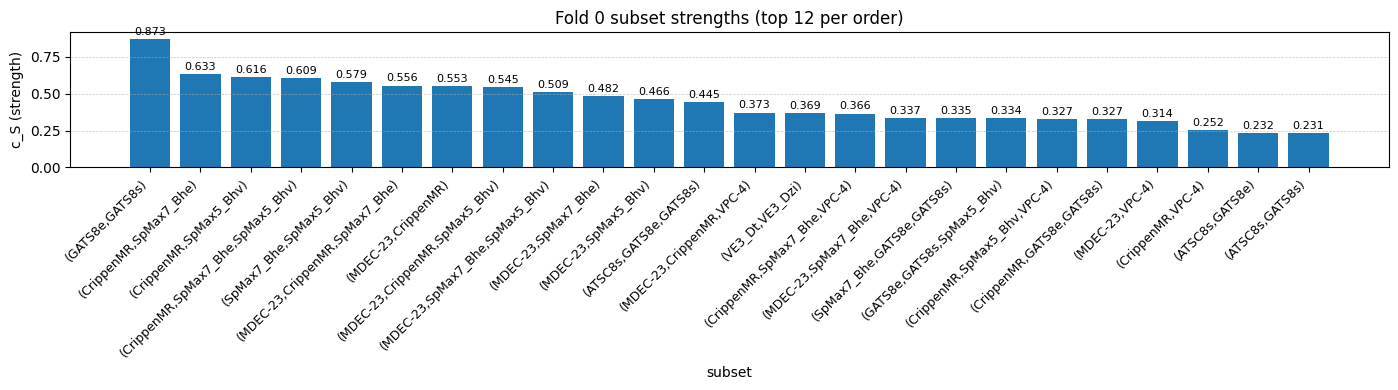

Saved results to subset_strengths_results\c_s_fold0.csv and subset_strengths_results\c_s_fold0.json

=== Fold 1 (train n=137, test n=34) ===
Computing pairwise MI matrix for 13 features (KNN, k=5)...
Evaluating all subsets of size k=2 (total comb = 78)...
  picked top 12 subsets of order 2
Evaluating all subsets of size k=3 (total comb = 286)...
  picked top 12 subsets of order 3
Saved plot to subset_strengths_results\subset_strengths_fold1.png


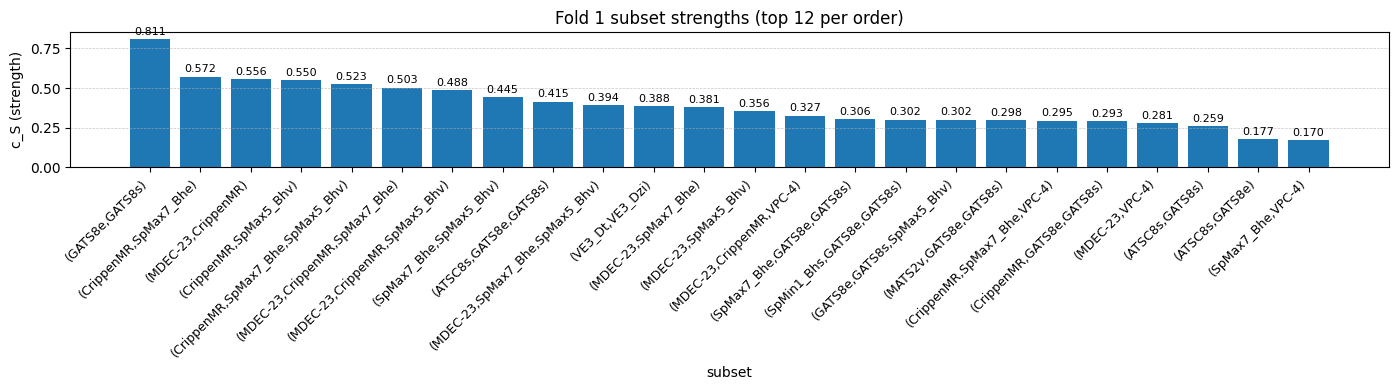

Saved results to subset_strengths_results\c_s_fold1.csv and subset_strengths_results\c_s_fold1.json

=== Fold 2 (train n=137, test n=34) ===
Computing pairwise MI matrix for 13 features (KNN, k=5)...
Evaluating all subsets of size k=2 (total comb = 78)...
  picked top 12 subsets of order 2
Evaluating all subsets of size k=3 (total comb = 286)...
  picked top 12 subsets of order 3
Saved plot to subset_strengths_results\subset_strengths_fold2.png


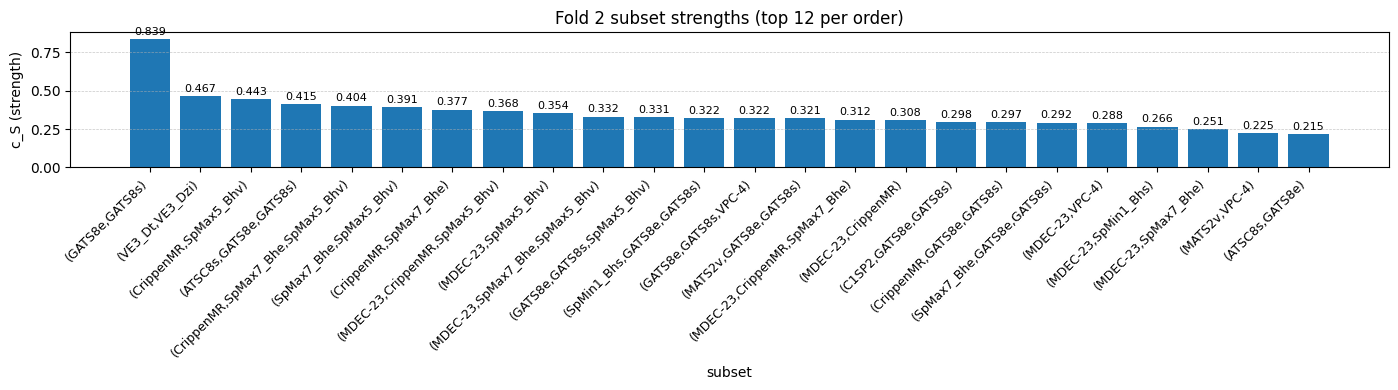

Saved results to subset_strengths_results\c_s_fold2.csv and subset_strengths_results\c_s_fold2.json

=== Fold 3 (train n=137, test n=34) ===
Computing pairwise MI matrix for 13 features (KNN, k=5)...
Evaluating all subsets of size k=2 (total comb = 78)...
  picked top 12 subsets of order 2
Evaluating all subsets of size k=3 (total comb = 286)...
  picked top 12 subsets of order 3
Saved plot to subset_strengths_results\subset_strengths_fold3.png


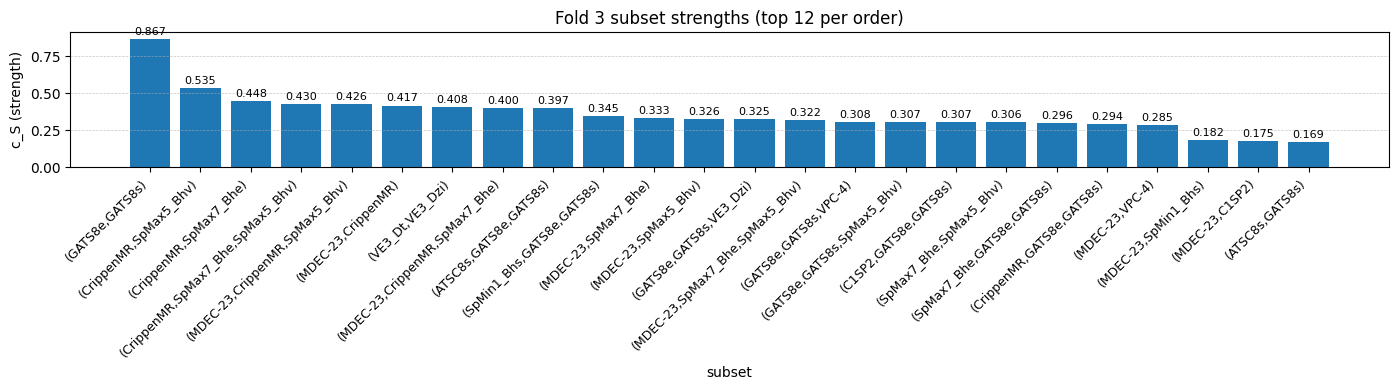

Saved results to subset_strengths_results\c_s_fold3.csv and subset_strengths_results\c_s_fold3.json

=== Fold 4 (train n=137, test n=34) ===
Computing pairwise MI matrix for 13 features (KNN, k=5)...
Evaluating all subsets of size k=2 (total comb = 78)...
  picked top 12 subsets of order 2
Evaluating all subsets of size k=3 (total comb = 286)...
  picked top 12 subsets of order 3
Saved plot to subset_strengths_results\subset_strengths_fold4.png


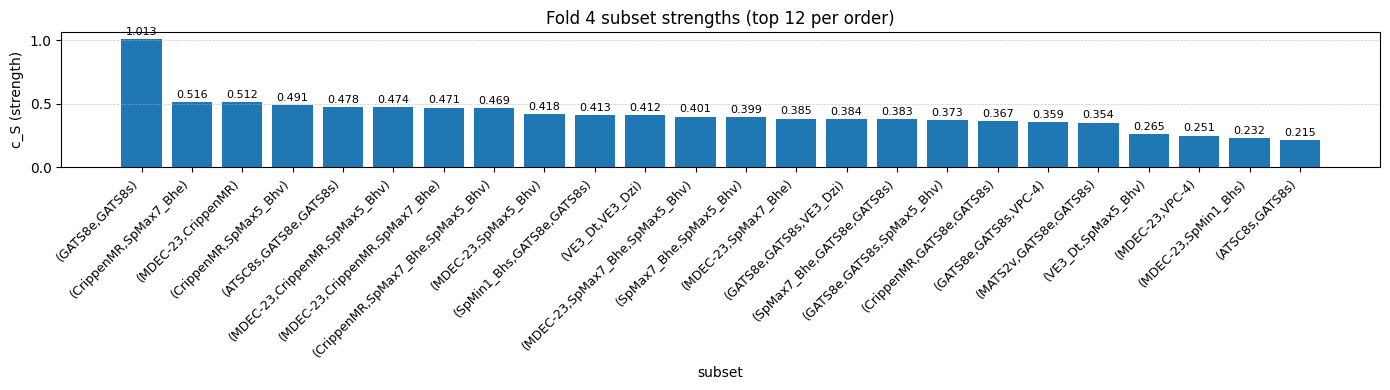

Saved results to subset_strengths_results\c_s_fold4.csv and subset_strengths_results\c_s_fold4.json


In [6]:
# ----------------- main block -----------------
if __name__ == "__main__":
    # === User settings ===
    dataset_save = r"C:/Users/jiriv/Documents/škola/Diplom_thesis/Quantum-feature-maps/Dataset/Toxicity-13F.csv"
    max_order = 3               # compute pairs and triplets
    top_k_per_order = 12        # how many top subsets per order to return
    n_neighbors = 5             # K in KNN MI estimator
    random_state = 42
    save_results_dir = "subset_strengths_results"
    os.makedirs(save_results_dir, exist_ok=True)

    # === load data ===
    df = pd.read_csv(dataset_save)
    # convert class labels as you described (non-toxic -> 0, toxic -> 1)
    df['Class'] = df['Class'].apply(lambda v: 1 if str(v).strip().lower().startswith('non') else 0)
    feature_names = list(df.columns[:-1])
    X_raw = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    print("Loaded dataset:", dataset_save)
    print("n_samples, n_features:", X_raw.shape)

    # standardize
    scaler = StandardScaler()
    X = scaler.fit_transform(X_raw)

    # Option: compute per-fold (recommended) or global
    do_per_fold = True

    if do_per_fold:
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        fold_results = []
        for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
            print(f"\n=== Fold {fold_idx} (train n={len(train_idx)}, test n={len(test_idx)}) ===")
            X_train = X[train_idx]
            # compute top subsets on training data only
            c_s_train = generate_top_subsets_by_mi(
                X_train,
                feature_idx=None,
                max_order=max_order,
                top_k_per_order=top_k_per_order,
                n_neighbors=n_neighbors,
                random_state=random_state + fold_idx
            )
            # plot and save
            png_path = os.path.join(save_results_dir, f"subset_strengths_fold{fold_idx}.png")
            df_plot = plot_subset_strengths(
                c_s_train,
                feature_names=feature_names,
                title=f"Fold {fold_idx} subset strengths (top {top_k_per_order} per order)",
                figsize=(14,4),
                kind="bar",
                save_path=png_path
            )
            # save c_s dict to CSV and JSON
            csv_path = os.path.join(save_results_dir, f"c_s_fold{fold_idx}.csv")
            json_path = os.path.join(save_results_dir, f"c_s_fold{fold_idx}.json")
            # prepare DataFrame with subset (as indices) and strength
            out_rows = []
            for subset_idx, strength in c_s_train.items():
                out_rows.append({"subset_indices": subset_idx, "subset_names": "(" + ",".join(feature_names[i] for i in subset_idx) + ")", "strength": strength})
            pd.DataFrame(out_rows).to_csv(csv_path, index=False)
            with open(json_path, "w") as jf:
                json.dump({str(k): v for k,v in c_s_train.items()}, jf, indent=2)
            print(f"Saved results to {csv_path} and {json_path}")
            fold_results.append((c_s_train, df_plot))

        # Optionally: aggregate counts across folds to see stable subsets
        # (left as an exercise — you can intersect or sum strengths across folds)
    else:
        # global (single run on whole X)
        c_s_global = generate_top_subsets_by_mi(X, feature_idx=None, max_order=max_order,
                                               top_k_per_order=top_k_per_order, n_neighbors=n_neighbors,
                                               random_state=random_state)
        png_path = os.path.join(save_results_dir, "subset_strengths_global.png")
        df_plot = plot_subset_strengths(c_s_global, feature_names=feature_names, title="Global subset strengths", save_path=png_path)
        csv_path = os.path.join(save_results_dir, "c_s_global.csv")
        pd.DataFrame([{"subset_indices": k, "subset_names": "(" + ",".join(feature_names[i] for i in k) + ")", "strength": v} for k,v in c_s_global.items()]).to_csv(csv_path, index=False)
        print(f"Saved results to {csv_path}")

Build circuit for H(x) - useless, we need H_ad 

In [4]:
n_qubits = X.shape[1]  # number of qubits corresponds to number of features

def single_body_term(qc: QuantumCircuit, qubit: int, coef: float, dt: float):
     theta = 2.0 * float(coef) * dt # RZ gate angle (since RZ(phi) = exp(-i phi/2 Z)) needs to be doubled
     qc.rz(theta, qubit)

def multi_body_term(qc: QuantumCircuit, qubits: Sequence[int], coef: float, dt: float):
    qubits = list(qubits)
    n = len(qubits)

    if n == 0:
        return
    if n == 1:
        # single-qubit handled separately but keep for safety
        single_body_term(qc, qubits[0], coef, dt)
        return
     
    # Build ladder: CX(q0,q1), CX(q1,q2), ... mapping parity -> last qubit - redo when mapping done on quantum hardware
    # We will use a chain of CXs: for i in range(k-1): CX(qubits[i], qubits[i+1])
    for i in range(n - 1):
        qc.cx(qubits[i], qubits[i + 1])

    # Apply rotation on last qubit
    phi = 2.0 * dt * coef
    qc.rz(phi, qubits[-1])

    # Undo ladder
    for i in reversed(range(n - 1)):
        qc.cx(qubits[i], qubits[i + 1])

     

def build_circuit(n_qubits: int,
    x: Sequence[float],
    subsets: Sequence[Tuple[int, ...]],
    c_s: Dict[Tuple[int, ...], float],
    dt: float = 1.0)-> QuantumCircuit:
    """
    Construct a single Trotter-step circuit for counterdiabatic evolution
    under the Hamiltonian H = sum_i x_i Z_i + sum_{i<j} J_ij Z_iZ_j + sum K_ijk Z_iZ_jZ_k.
    The initial state is |+>^n (Hadamards), then we apply exp(-i H dt).
    """

    if len(x) != n_qubits:
        raise ValueError("length of x must match n_qubits")

    qc = QuantumCircuit(n_qubits)

    # Initialize to |+> on all qubits (ground state of X-field Hamiltonian)
    qc.h(range(n_qubits))
    
    # part sum_i x_i*sigma_i^z
    for i in range(n_qubits):
        x_i = x[i]
        if x_i != 0.0:
            single_body_term(qc, i, x_i, dt)
    
    # part K=2: sum_{S in G^k} c_s prod_{i in subset} sigma_i^z*sigma_j^z
    for S in subsets:
        subset = tuple(S)
        if subset == () or subset is None:
            continue
        if len(subset) == 1:
            # if present in c_s, treat as single-body (rare)
            coef = float(c_s.get(subset, 0.0))
            if coef != 0.0:
                single_body_term(qc, subset[0], coef, dt)
        else:
            # multi-body term
            coef = float(c_s.get(subset, 0.0))
            if coef != 0.0:
                if any((idx < 0 or idx >= n_qubits) for idx in subset):
                        raise IndexError("subset contains invalid qubit index")
                multi_body_term(qc, subset, coef, dt)
    return qc

In [5]:
if __name__ == "__main__":
    # 1) toy example: 4 qubits
    n_q = 4
    # example feature vector x (mapped to single Z fields)
    x = [0.5, -0.7, 0.0, 0.2]
    # example subsets: pair (0,1), triplet (1,2,3)
    subsets = [(0,1), (1,2,3)]
    # example c_S coefficients (these would come from your MI computations)
    c_s = {
        (0,1): 0.9,         # two-body coupling strength
        (1,2,3): 0.15       # three-body coupling strength
    }

    circ = build_circuit(n_q, x, subsets, c_s)
    print(circ.draw(output="text"))

     ┌───┐ ┌───────┐                                                      
q_0: ┤ H ├─┤ Rz(1) ├────■───────────────■─────────────────────────────────
     ├───┤┌┴───────┴─┐┌─┴─┐┌─────────┐┌─┴─┐                               
q_1: ┤ H ├┤ Rz(-1.4) ├┤ X ├┤ Rz(1.8) ├┤ X ├──■─────────────────────────■──
     ├───┤└──────────┘└───┘└─────────┘└───┘┌─┴─┐                     ┌─┴─┐
q_2: ┤ H ├─────────────────────────────────┤ X ├──■───────────────■──┤ X ├
     ├───┤┌─────────┐                      └───┘┌─┴─┐┌─────────┐┌─┴─┐└───┘
q_3: ┤ H ├┤ Rz(0.4) ├───────────────────────────┤ X ├┤ Rz(0.3) ├┤ X ├─────
     └───┘└─────────┘                           └───┘└─────────┘└───┘     


Alpha calculation

In [7]:
alpha = 1.0

Gauge potential

In [25]:
n_trotter_steps = 1
delta_t = 1.0
T = n_trotter_steps * delta_t

def build_A_circuit(n_qubits: int, X: Sequence[float], subsets: Sequence[Tuple[int, ...]], c_s: Dict[Tuple[int, ...], float], T: float) -> QuantumCircuit:
    if len(x) != n_qubits:
        raise ValueError("length of x must match n_qubits")
       
    qc = QuantumCircuit(n_qubits)

    # Initialize to |+> on all qubits (ground state of X-field Hamiltonian)
    qc.h(range(n_qubits))

    pauli_labels = []
    coeffs = []

    # single-body term
    for i, x_i in enumerate(X):
        label = ['I'] * n_qubits
        label[i] = 'Y'
        pauli_labels.append(''.join(label))
        coeffs.append(x_i)

    
    # multi-body terms
    for S in subsets:
        subset = tuple(S)
        if subset == () or subset is None:
            continue
        #if len(subset) == 1:
            #coef = float(c_s.get(subset, 0.0))
            #if coef != 0.0:
                #single_body_term(qc, subset[0], coef, dt)
        else:
            coef = float(c_s.get(subset, 0.0))
            if coef != 0.0:
                if any((idx < 0 or idx >= n_qubits) for idx in subset):
                    raise IndexError("subset contains invalid qubit index")
                for i in S:
                    label = ['I']*n_qubits
                    label[i] = 'Y'
                    for j in S:
                        if j != i:
                            label[j] = 'Z'
                pauli_labels.append(''.join(label))
                coeffs.append(coef)
    # prefactor 2*alpha*(A*B' - B*A')
    def prefactor(alpha: float, t: float, T: float)-> float:
        A = np.sin((np.pi*np.sin((np.pi*t)/2*T)**2)/2)**2
        B = np.cos((np.pi*np.sin((np.pi*t)/2*T)**2)/2)**2
        A_prime = (np.pi**2/T) * np.sin((np.pi*t)/T) * np.sin((np.pi*t)**2/(2*T**2)) * np.cos((np.pi*t)**2/(2*T**2))
        B_prime = -(np.pi**2/T) * np.sin((np.pi*t)/T) * np.sin((np.pi*t)**2/(2*T**2)) * np.cos((np.pi*t)**2/(2*T**2))
        return 2*alpha*(A*B_prime - B*A_prime)

    # Build SparsePauliOp
    ham_0 = SparsePauliOp(pauli_labels, np.array(coeffs))
    ham = prefactor(alpha, delta_t, T) * ham_0

    # Build the evolution gate
    evo = PauliEvolutionGate(ham, time=T, synthesis=LieTrotter(reps=1))

    # Append the evolution gate to the circuit
    qc.append(evo, range(n_qubits))

    return qc

    
    

In [26]:
if __name__ == "__main__":
    # 1) toy example: 4 qubits
    n_q = 4
    # example feature vector x (mapped to single Z fields)
    x = [0.5, -0.7, 0.0, 0.2]
    # example subsets: pair (0,1), triplet (1,2,3)
    subsets = [(0,1), (1,2,3)]
    # example c_S coefficients (these would come from your MI computations)
    c_s = {
        (0,1): 0.9,         # two-body coupling strength
        (1,2,3): 0.15       # three-body coupling strength
    }

    circ = build_A_circuit(n_q, x, subsets, c_s, T)
    print(circ.draw(output="text"))

     ┌───┐┌────────────────────────────────────────────────────────┐
q_0: ┤ H ├┤0                                                       ├
     ├───┤│                                                        │
q_1: ┤ H ├┤1                                                       ├
     ├───┤│  exp(-it (YIII + IYII + IIYI + IIIY + ZYII + IZZY))(1) │
q_2: ┤ H ├┤2                                                       ├
     ├───┤│                                                        │
q_3: ┤ H ├┤3                                                       ├
     └───┘└────────────────────────────────────────────────────────┘


Measurement

Classification

In [27]:
def classification(X, y):
    clf = GradientBoostingClassifier(n_estimators=1000, random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    return np.mean(scores), np.std(scores)

In [ ]:
from typing import Sequence, Tuple, Dict, Iterable
from qiskit import QuantumCircuit
from math import pi
import numpy as np

# ----------------- Low-level helpers -----------------
def _basis_change_to_z_for(pauli: str, qc: QuantumCircuit, q: int):
    """
    Map local Pauli to Z by conjugation:
      - if pauli == 'Z' : nothing
      - if pauli == 'X' : H (H X H = Z)
      - if pauli == 'Y' : RX(pi/2) (Rx(pi/2) Y Rx(-pi/2) = Z)
    Note: we use RX for Y->Z basis change (correct).
    """
    p = pauli.upper()
    if p == 'Z':
        return
    if p == 'X':
        qc.h(q)
    elif p == 'Y':
        qc.rx(pi/2, q)
    else:
        raise ValueError("Unsupported Pauli: " + str(pauli))

def _undo_basis_change_for(pauli: str, qc: QuantumCircuit, q: int):
    p = pauli.upper()
    if p == 'Z':
        return
    if p == 'X':
        qc.h(q)            # H is self-inverse
    elif p == 'Y':
        qc.rx(-pi/2, q)    # undo RX(pi/2)
    else:
        raise ValueError("Unsupported Pauli: " + str(pauli))

def _apply_parity_phase(qc: QuantumCircuit, qubits: Sequence[int], angle: float):
    """
    Apply phase exp(-i * angle/2 * Z_last) using CX ladder:
    - ladder: CX(q0,q1), CX(q1,q2), ...
    - RZ(angle) on last qubit (we pass angle already equal to 2*dt*coef)
    - undo ladder
    """
    k = len(qubits)
    if k == 1:
        qc.rz(angle, qubits[0])
        return
    for i in range(k-1):
        qc.cx(qubits[i], qubits[i+1])
    qc.rz(angle, qubits[-1])
    for i in reversed(range(k-1)):
        qc.cx(qubits[i], qubits[i+1])

# ----------------- Pauli-string exponentiation -----------------
def exp_pauli_string_correct(
    qc: QuantumCircuit,
    pauli_string: Sequence[Tuple[int,str]],
    coef: float,
    dt: float,
    prune_threshold: float = 0.0
):
    """
    Implement U = exp(-i dt * coef * P) where P = tensor product of given Paulis.
    - For single-qubit Y exponentials, use RY directly: RY(phi) with phi=2*dt*coef.
    - For multi-qubit strings, map each local Pauli -> Z (H for X, RX(pi/2) for Y),
      then use parity ladder + RZ(2*dt*coef), and undo basis-changes.
    """
    if abs(coef) <= prune_threshold:
        return

    if len(pauli_string) == 0:
        return

    if len(pauli_string) == 1:
        qidx, p = pauli_string[0]
        p = p.upper()
        phi = 2.0 * dt * float(coef)  # R_gate(angle) uses angle = 2*dt*coef
        if p == 'Z':
            qc.rz(phi, qidx)          # RZ implements exp(-i phi/2 Z) -> gives exp(-i dt coef Z)
        elif p == 'X':
            # RX(phi) = exp(-i phi/2 X) so use RX for single-X
            qc.rx(phi, qidx)
        elif p == 'Y':
            # RY(phi) = exp(-i phi/2 Y) so use RY for single-Y as requested
            qc.ry(phi, qidx)
        else:
            raise ValueError("Unsupported single-qubit Pauli: " + p)
        return

    # Multi-qubit case: do basis changes, parity-ladder -> RZ -> undo
    qubits = [int(q) for (q,p) in pauli_string]
    paulis = [p.upper() for (q,p) in pauli_string]

    # 1) basis changes so each local op becomes Z
    for q, p in zip(qubits, paulis):
        _basis_change_to_z_for(p, qc, q)

    # 2) parity-phase: RZ with angle = 2*dt*coef on last qubit with ladder
    angle = 2.0 * dt * float(coef)
    _apply_parity_phase(qc, qubits, angle)

    # 3) undo basis changes (reverse order)
    for q, p in reversed(list(zip(qubits, paulis))):
        _undo_basis_change_for(p, qc, q)

# ----------------- Build UA circuit from scratch -----------------
def build_UA_from_scratch(
    n_qubits: int,
    x: Sequence[float],
    subsets: Iterable[Tuple[int,...]],
    c_s: Dict[Tuple[int,...], float],
    dt: float = 1.0,
    prune_threshold: float = 0.0,
    init_plus_state: bool = False
) -> QuantumCircuit:
    """
    Build U_A(dt) = exp(-i dt * A_bracket) with
      A_bracket = sum_i x_i Y_i + sum_{k=2}^3 sum_{S in G(k)} c_S sum_{i in S} (prod_{j in S\{i}} Z_j) Y_i

    Parameters:
      - n_qubits: number of qubits
      - x: sequence of length n_qubits (alpha_i)
      - subsets: iterable of subset-tuples S (global indices)
      - c_s: dict mapping S tuple -> c_S
      - dt: timestep
      - prune_threshold: skip pauli-strings with |coef| <= threshold
      - init_plus_state: if True, apply H to prepare |+>^n before UA (optional)
    Returns:
      - QuantumCircuit implementing U_A(dt)
    """
    if len(x) != n_qubits:
        raise ValueError("x length mismatch")

    qc = QuantumCircuit(n_qubits)

    if init_plus_state:
        qc.h(range(n_qubits))

    # 1) single-body Y terms: coefficient = x_i -> use RY
    for i in range(n_qubits):
        coef = float(x[i])
        if abs(coef) <= prune_threshold:
            continue
        # single-qubit Y: RY(phi) with phi = 2*dt*coef
        exp_pauli_string_correct(qc, [(i,'Y')], coef, dt, prune_threshold=prune_threshold)

    # 2) multi-body terms for k=2..3: for each S and each i in S add (Z on others) Y_i with coef = c_S * x_i
    for S in subsets:
        S_t = tuple(int(s) for s in S)
        cval = float(c_s.get(S_t, 0.0))
        if abs(cval) == 0.0:
            continue
        k = len(S_t)
        if k < 2 or k > 3:
            # skip outside requested k-range
            continue
        for i in S_t:
            coef = cval * float(x[int(i)])   # your requested beta_{S,i} = x_i, so coefficient = c_S * x_i
            if abs(coef) <= prune_threshold:
                continue
            # pauli string: Y at i, Z on others (order matters for ladder; we use S_t order)
            pauli_string = []
            for q in S_t:
                if q == int(i):
                    pauli_string.append((q, 'Y'))
                else:
                    pauli_string.append((q, 'Z'))
            exp_pauli_string_correct(qc, pauli_string, coef, dt, prune_threshold=prune_threshold)

    return qc

# ----------------- Example usage -----------------
if __name__ == "__main__":
    # small example: 5 qubits, synthetic x and subsets
    n_q = 5
    # example feature vector (alpha_i)
    x = [0.4, -0.3, 0.0, 0.2, 0.1]
    # example c_s dict for pairs and triplets
    subsets = [(0,1), (1,2,3), (0,2), (3,4)]
    c_s = {(0,1): 0.9, (1,2,3): 0.15, (0,2): 0.05, (3,4): 0.2}
    dt = 0.8
    qc = build_UA_from_scratch(n_q, x, subsets, c_s, dt=dt, prune_threshold=1e-6, init_plus_state=True)
    print("UA circuit depth:", qc.depth(), "ops:", qc.count_ops())
    print(qc.draw(output='text', fold=120))


UA circuit depth: 32 ops: OrderedDict([('cx', 18), ('rx', 14), ('rz', 7), ('h', 5), ('ry', 4)])
     ┌───┐ ┌──────────┐┌─────────┐                       ┌──────────┐                        ┌─────────┐            »
q_0: ┤ H ├─┤ Ry(0.64) ├┤ Rx(π/2) ├──■─────────────────■──┤ Rx(-π/2) ├──■──────────────────■──┤ Rx(π/2) ├────────────»
     ├───┤┌┴──────────┤└─────────┘┌─┴─┐┌───────────┐┌─┴─┐├─────────┬┘┌─┴─┐┌────────────┐┌─┴─┐├─────────┴┐┌─────────┐»
q_1: ┤ H ├┤ Ry(-0.48) ├───────────┤ X ├┤ Rz(0.576) ├┤ X ├┤ Rx(π/2) ├─┤ X ├┤ Rz(-0.432) ├┤ X ├┤ Rx(-π/2) ├┤ Rx(π/2) ├»
     ├───┤└───────────┘           └───┘└───────────┘└───┘└─────────┘ └───┘└────────────┘└───┘└──────────┘└─────────┘»
q_2: ┤ H ├──────────────────────────────────────────────────────────────────────────────────────────────────────────»
     ├───┤ ┌──────────┐                                                                                             »
q_3: ┤ H ├─┤ Ry(0.32) ├───────────────────────────────────────────────────────